# Papers:

https://www.semanticscholar.org/paper/Analysis-of-focus-measure-operators-for-Pertuz-Puig/8c675bf5b542b98bf81dcf70bd869ab52ab8aae9?p2df
https://pyimagesearch.com/2020/06/15/opencv-fast-fourier-transform-fft-for-blur-detection-in-images-and-video-streams/

### Import modules and image loading

In [28]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load an image from the 'images' folder
image_path = os.path.join('images', 'soapbubbles.png')

# Read the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

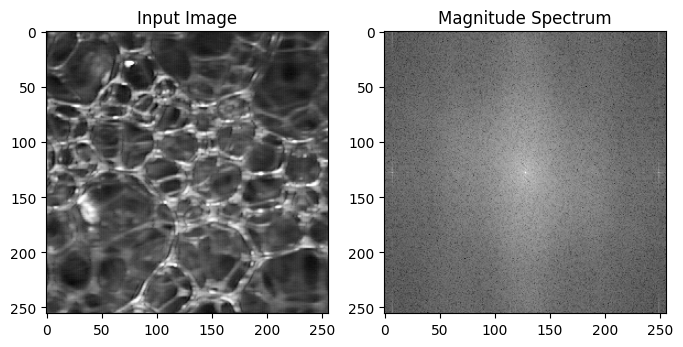

In [31]:
# Compute the 2D DFT and return the magnitude spectrum
ftt = np.fft.fft2(image)
ftts = np.fft.fftshift(ftt)
magnitude = 20 * np.log(np.abs(ftts))

# print the image and the magnitude spectrum
plt.figure(figsize=(8, 8))
plt.subplot(121), 
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.subplot(122),
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitude Spectrum')
plt.show()


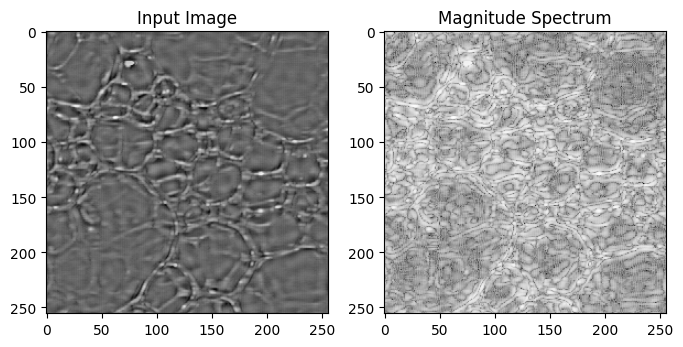

In [37]:
# create a mask first, center square is 1, remaining all zeros
size = 15
high_pass_mask = np.ones(image.shape)
rows, cols = image.shape
high_pass_mask[
    rows // 2 - size : rows // 2 + size,
    cols // 2 - size : cols // 2 + size
] = 0

# apply the mask to the fft obtained in the previous section and display the results
ftt_filtered = ftts * high_pass_mask
new_img = np.fft.ifftshift(ftt_filtered)
new_img = np.fft.ifft2(new_img)

new_magnitude = 20 * np.log(np.abs(new_img))

# remove the imaginary part
new_img = np.real(new_img)

# print the image and the magnitude spectrum
plt.figure(figsize=(8, 8))
plt.subplot(121),
plt.imshow(new_img, cmap='gray')
plt.title('Input Image')
plt.subplot(122),
plt.imshow(new_magnitude, cmap='gray')
plt.title('Magnitude Spectrum')
plt.show()